# Tutorial CV2 - Classification with a squeezing feature map

In this tutorial we implement the squeezing feature map together with the "implicit" linear classifier inspired by Schuld and Killoran (arXiv:1803.07128). 

### Imports

We import Penny Lane, its numpy as well as an optimizer. 

*Note: We use np for all numpy processing outside of the cost function, and onp for numpy processing of which gradients have to be calculated.*

In [1]:
import numpy as np
import pennylane as qm
from pennylane import numpy as onp
from pennylane.optimize import AdamOptimizer

The device is the Strawberry Fields simulator with two quantum modes or "wires". You need to have the Strawberry Fields plugin to Penny Lane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=20)
    
except:
    print("To run this tutorial you need to install the strawberryfields plugin...")

### Quantum node

The variational circuit which defines the quantum node consists of two parts. First, the input is "encoded into Hilbert space" by a squeezing feature map.

In [3]:
def featuremap(x):

    qml.Squeezing(1.9, x[0], wires=[0])
    qml.Squeezing(1.9, x[1], wires=[1])

Next, a layered circuit serves as a trainable linear classifier in Hilbert space. A single layer is defined as:

In [4]:
def layer(v):

    qml.Beamsplitter(v[0], v[1], wires=[0, 1])

    # linear gates in quadrature
    qml.Displacement(v[2], 0., wires=[0])
    qml.Displacement(v[3], 0., wires=[1])

    # quadratic gates in quadrature
    qml.QuadraticPhase(v[4], wires=[0])
    qml.QuadraticPhase(v[5], wires=[1])

    # cubic gates in quadrature
    qml.CubicPhase(v[6], wires=[0])
    qml.CubicPhase(v[7], wires=[1])

We use two variational circuits or quantum nodes. Both first encode the input via the feature map and then execute the layers. However, while the first quantum node returns the expectation of measuring 2 photons in Mode 0 and 0 photons in Mode 1 (Fock state |2,0>), the second quantum node returns the expectation of Fock state |0,2>.

In [5]:
@qml.qnode(dev)
def circuit1(var, x=None):

    featuremap(x)

    for v in var:
        layer(v)

    return qml.expval.NumberState(np.array([2, 0]), [0, 1])


@qml.qnode(dev)
def circuit2(var, x=None):

    featuremap(x)

    for v in var:
        layer(v)

    return qml.expval.NumberState(np.array([0, 2]), [0, 1])

The quantum classifier executes thes circuits and computes the renormalized probability of measuring Fock state  |2,0> instead of |0,2>.

In [6]:
def qclassifier(var, x=None):

    p1 = circuit1(var, x=x)
    p2 = circuit2(var, x=x)

    return p1 / (p1 + p2)

### Objective

As an objective we take the square loss between target labels and model predictions. To check the quality of the classifier, we also define the accuracy, or the share of correctly classified samples.

In [7]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)

    return loss


def accuracy(labels, predictions):

    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l-p) < 1e-5:
            acc += 1
    acc = acc/len(labels)

    return acc

We also consider a regularizer.

In [8]:
def regularizer(var):

    reg = onp.sum(onp.inner(var, var))

    return reg

In the cost function we compute the outputs from the variational circuit and compute the square loss.

In [9]:
def cost(var, X, Y):

    regul = regularizer(var)

    outpts = [qclassifier(var, x=x) for x in X]

    loss = square_loss(Y, outpts)

    return loss + 0.001*regul

### Optimization

We load data samples from the moons data set and split it into a training and validation set.

In [10]:
# load function data
data = np.loadtxt("moons.txt")
X = data[:, 0:2]
Y = data[:, 2]

# split into training and validation set
num_data = len(Y)
num_train = int(0.5*num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[: num_train]]
Y_train = Y[index[: num_train]]
X_val = X[index[num_train: ]]
Y_val = Y[index[num_train: ]]

Let's plot the data.

*Note: For the next cell to work you need python's matplotlib library.* 

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_train[:,0][Y_train==0], X_train[:,1][Y_train==0], marker='o', color='red', label='train 0')
plt.scatter(X_val[:,0][Y_val==0], X_val[:,1][Y_val==0], marker='^', color='red', label='validation 0')
plt.scatter(X_train[:,0][Y_train==1], X_train[:,1][Y_train==1], marker='^', color='blue', label='train 1')
plt.scatter(X_val[:,0][Y_val==1], X_val[:,1][Y_val==1], marker='o', color='blue', label='validation 1')
plt.xlabel('x1')
plt.ylabel('x2')

plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

The trainable circuit parameters (called variables in PennyLane), are initialized with values sampled from a normal distribution. We use 4 layers.

In [12]:
# initialize weights
num_layers = 4
var_init = 0.5*np.random.randn(num_layers, 8)

var_init

array([[-0.77881696, -0.57462665,  0.49044164, -1.05210498, -0.0057898 ,
         0.2994548 ,  0.48964228, -0.98985854],
       [-0.3158102 ,  0.26935779, -0.71983469, -0.43611422,  0.68195369,
         0.68343315,  0.26761499,  0.70371984],
       [ 0.08754595,  0.10345114, -0.23520697,  0.28040479,  0.10544445,
         0.46985983,  0.44838878,  0.05921923],
       [-0.17717562,  0.54940329,  0.06196285, -0.30759871,  0.42008822,
         0.20511646,  0.00128893,  0.36773939]])

We choose the Adam optimizer and update the weights for 50 steps with a batch size of 5. In every step the accuracy is computed for the entire training set. *You will see that while the cost is going down on average, there are fluctuations in the training. You could choose a smaller stepsize to make training smoother. Eventially, the accuracy of the training and validation set should be close to 1.0.*

In [ ]:
# create optimizer
o = AdamOptimizer(stepsize=0.005)

# train
batch_size = 5
var = var_init

for it in range(50):

    # select minibatch of training samples
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]

    var = o.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)

    # Compute accuracy on train and validation set
    pred_train = [np.round(qclassifier(var, x=x_)) for x_ in X_train]
    pred_val = [np.round(qclassifier(var, x=x_)) for x_ in X_val]
    acc_train = accuracy(Y_train, pred_train)
    acc_val = accuracy(Y_val, pred_val)
     
    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
     "".format(it+1, cost(var, X_train, Y_train), acc_train, acc_val))

Iter:     1 | Cost: 0.4481376 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 0.4399540 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     3 | Cost: 0.4291105 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     4 | Cost: 0.4140978 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     5 | Cost: 0.3961359 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     6 | Cost: 0.3730437 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     7 | Cost: 0.3490189 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     8 | Cost: 0.3229352 | Acc train: 0.5200000 | Acc validation: 0.5000000 
Iter:     9 | Cost: 0.2958892 | Acc train: 0.5800000 | Acc validation: 0.5400000 
Iter:    10 | Cost: 0.2683025 | Acc train: 0.6200000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 0.2424237 | Acc train: 0.7000000 | Acc validation: 0.6000000 
Iter:    12 | Cost: 0.2218238 | Acc train: 0.7600000 | Acc validation: 0.7000000 
Iter:    13 | Co

With the last predictions we can plot the classification of the model for the data. *For the following cell you need to have imported matplotlib's pyplot above.*

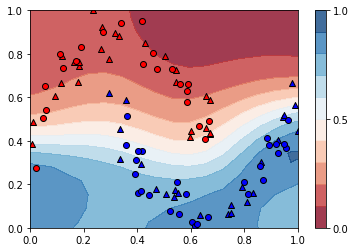

In [15]:
# make data for plot
xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 20), np.linspace(-0.1, 1.1, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# start plot
plt.figure()
cm = plt.cm.RdBu  

# plot decision regions
predictions_grid = [qclassifier(var, x=x) for x in X_grid]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X_train[:, 0][Y_train==0], X_train[:, 1][Y_train==0], c='r', marker='^', edgecolors='k')
plt.scatter(X_train[:, 0][Y_train==1], X_train[:, 1][Y_train==1], c='b', marker='^', edgecolors='k')
plt.scatter(X_val[:, 0][Y_val==0], X_val[:, 1][Y_val==0], c='r', marker='o', edgecolors='k')
plt.scatter(X_val[:, 0][Y_val==1], X_val[:, 1][Y_val==1], c='b', marker='o', edgecolors='k')

plt.xlim(0., 1)
plt.ylim(0., 1)
plt.show()